In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import time

%run ../global_variables.py ./
%run ../global_functions.py ./

This notebook compute 3 performance metrics (NSE, PBIAS and correlation) for given datasets and a selection of basins. Part 1 selects the basin, the datasets and run through all of them while saving results. Part 2 plots results.

<div class="alert alert-block alert-info">
There is no need to run Part 1, results are already saved. You can jump to part 2 to plot performance tables.
</div>

# 1. Compute performance matrices for selected datasets and basins

We select the basins we want to study. `NB_RUNOFF` is the number of runoff stations from [GRDC](https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/grdc_stations_ftp.html) operating at least 1 year between 2003 and 2017, inside each basin.

In [2]:
approximate=True # 5 approximate climate zones, or 31 smaller ones 
basins=load_basins_data(approximate)

In [3]:
# we select basins larger than 65 000 km2 with at least 1 runoff station, or larger than 800,000 km2
selected_basins=basins.loc[basins['RASTAREA']>=6.5e4,['COLOR','MAIN_CLIMATE','CLIMATE_AREA_%','RASTAREA','NB_RUNOFF','geometry']]

# remove Greenland and Antarctica if they have been selected
to_remove=['GREENLAND','ANTARCTICA','KASPIAN SEA (DL)']
for remove_basin in to_remove:
    if np.sum(selected_basins.index.isin([remove_basin]))>0:
        selected_basins.drop(remove_basin,inplace=True)

Nbasins=selected_basins.shape[0]
print("You selected {} basins, among which \n {} belong to equatorial zone \n {} to arid zone \n {} to warm temperate zone \n {} to snow zone \n {} to polar zone".format(Nbasins,
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='A'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='B'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='C'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='D'].shape[0],
    selected_basins.loc[selected_basins['MAIN_CLIMATE']=='E'].shape[0]))

You selected 154 basins, among which 
 28 belong to equatorial zone 
 43 to arid zone 
 31 to warm temperate zone 
 51 to snow zone 
 1 to polar zone


We plot selected_basins

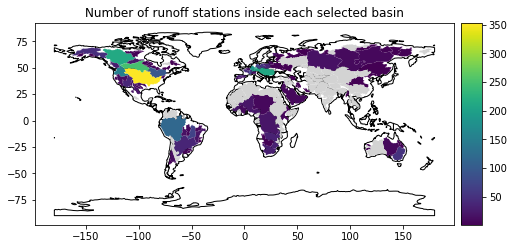

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

selected_basins_plot=selected_basins.copy()
selected_basins_plot['NB_RUNOFF']=np.where(selected_basins['NB_RUNOFF']==0,np.nan,selected_basins['NB_RUNOFF'])

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(ax=ax, color='white', edgecolor='black')
selected_basins_plot.plot(ax=ax,column='NB_RUNOFF',legend=True,cax=cax,missing_kwds={"color": "lightgrey",})
ax.set_title("Number of runoff stations inside each selected basin")
plt.show()

List of datasets available for each hydrological variable

In [4]:
list_data_P=['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLDAS22_CLSM25','MERRA2','MOD16','SSEBop']
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLDAS22_CLSM25','GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons','GRACE_CSR_grid','GRACE_ITSG_grid']
data_TWS='GRACE_JPL_mascons'

## Computation for all hydrological datasets, over selected basins + performance metrics saved

Is it the first time we run the code with these parameters ?

In [5]:
first_time=True

We initialize the results dataframe

In [6]:
datasets=[]
for d_P in list_data_P:
    for d_ET in list_data_ET:
        for d_R in list_data_R:
            datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))

In [7]:
len(datasets)

81

In [8]:
if first_time: 
    Ndatasets=0
    df=selected_basins.copy()
    df[datasets]=np.nan*np.ones((selected_basins.shape[0],len(datasets)))
    correlation_tab=df.copy()
    PBIAS_tab=df.copy()
    NSE_tab=df.copy()
    
else: # if we want to add new datasets to existing tabs
    Ndatasets=810
    correlation_tab=pd.read_csv("../results/water_budget/correlation_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
    PBIAS_tab=pd.read_csv("../results/water_budget/PBIAS_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])
    NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])    

In order to compare datasets coherently, the analysis is restricted to the period 2003-2014 where all datasets are available. 

In [9]:
time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]

For each dataset, we load the basin timeseries computed by the notebook `Save basins data`, compute the net accumulation and calculate performance metrics. Each performance is saved in the corresponding table.

In [10]:
TWS_month=pd.read_csv('../results/hydrology/TWS_{}_monthly_filtered.csv'.format(data_TWS),index_col=[0])
time_TWS=pd.to_datetime(TWS_month.columns.str[4+len(data_TWS):])

i=0
for data_P in list_data_P:  
    P_month=pd.read_csv('../results/hydrology/P_{}_monthly_filtered.csv'.format(data_P),index_col=[0])
    time_P=pd.to_datetime(P_month.columns.str[2+len(data_P):])
    
    for data_ET in list_data_ET:   
        ET_month=pd.read_csv('../results/hydrology/ET_{}_monthly_filtered.csv'.format(data_ET),index_col=[0])
        time_ET=pd.to_datetime(ET_month.columns.str[3+len(data_ET):])
        
        for data_R in list_data_R:   
            R_month=pd.read_csv('../results/hydrology/R_{}_monthly_filtered.csv'.format(data_R),index_col=[0])
            time_R=pd.to_datetime(R_month.columns.str[2+len(data_R):]) 
            
            i+=1
            print("dataset {}/{}".format(i,len(datasets)))

            for basin_name in selected_basins.index:
                P_filter=P_month.loc[basin_name,['P_{} {}'.format(data_P,d.date()) for d in time_idx]]
                ET_filter=ET_month.loc[basin_name,['ET_{} {}'.format(data_ET,d.date()) for d in time_idx]]
                R_filter=R_month.loc[basin_name,['R_{} {}'.format(data_R,d.date()) for d in time_idx]]
                TWSC_filter=TWS_month.loc[basin_name,['TWS_{} {}'.format(data_TWS,d.date()) for d in time_idx]]

                fillingP=(np.sum(np.isnan(P_filter))==0)
                fillingET=(np.sum(np.isnan(ET_filter))==0)
                fillingR=(np.sum(np.isnan(R_filter))==0)
                fillingTWS=(np.sum(np.isnan(TWSC_filter))==0)

                if fillingP&fillingET&fillingR&fillingTWS: # if this basin is entirely covered by all datasets, proceed, otherwise the loop ends
                    A_filter=pd.Series(P_filter.values-ET_filter.values-R_filter.values,index=time_idx)
                    TWSC_filter.index=time_idx
                    
                    # compute performance metrics
                    col='P_{}_ET_{}_R_{}_TWS_{}'.format(data_P,data_ET,data_R,data_TWS)
                    
                    corr=A_filter.corr(TWSC_filter)
                    correlation_tab.loc[basin_name,col]=corr

                    PBIAS=percentage_bias(A_filter,TWSC_filter)
                    PBIAS_tab.loc[basin_name,col]=PBIAS

                    NSE=compute_NSE(A_filter,TWSC_filter)
                    NSE_tab.loc[basin_name,col]=NSE

# sort datasets by alphabetic order before saving
datasets=correlation_tab.columns[np.where(correlation_tab.columns.str[:2]=='P_')]
no_datasets=correlation_tab.columns[np.where(correlation_tab.columns.str[:2]!='P_')]
correlation_tab2=correlation_tab[no_datasets].join(correlation_tab[datasets.sort_values()])
PBIAS_tab2=PBIAS_tab[no_datasets].join(PBIAS_tab[datasets.sort_values()])
NSE_tab2=NSE_tab[no_datasets].join(NSE_tab[datasets.sort_values()])

                
correlation_tab2.to_csv("../results/water_budget/correlation_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
PBIAS_tab2.to_csv("../results/water_budget/PBIAS_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
NSE_tab2.to_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,datasets.shape[0],data_TWS))
first_time=False

dataset 1/81
dataset 2/81
dataset 3/81
dataset 4/81
dataset 5/81
dataset 6/81
dataset 7/81
dataset 8/81
dataset 9/81
dataset 10/81
dataset 11/81
dataset 12/81
dataset 13/81
dataset 14/81
dataset 15/81
dataset 16/81
dataset 17/81
dataset 18/81
dataset 19/81
dataset 20/81
dataset 21/81
dataset 22/81
dataset 23/81
dataset 24/81
dataset 25/81
dataset 26/81
dataset 27/81
dataset 28/81
dataset 29/81
dataset 30/81
dataset 31/81
dataset 32/81
dataset 33/81
dataset 34/81
dataset 35/81
dataset 36/81
dataset 37/81
dataset 38/81
dataset 39/81
dataset 40/81
dataset 41/81
dataset 42/81
dataset 43/81
dataset 44/81
dataset 45/81
dataset 46/81
dataset 47/81
dataset 48/81
dataset 49/81
dataset 50/81
dataset 51/81
dataset 52/81
dataset 53/81
dataset 54/81
dataset 55/81
dataset 56/81
dataset 57/81
dataset 58/81
dataset 59/81
dataset 60/81
dataset 61/81
dataset 62/81
dataset 63/81
dataset 64/81
dataset 65/81
dataset 66/81
dataset 67/81
dataset 68/81
dataset 69/81
dataset 70/81
dataset 71/81
dataset 72/81
d

# 2. Results

## 2.1. Functions to plot nice tables

Function to draw column separation between datasets.

In [2]:
def find_separation_datasets(datasets):
    # name of datasets
    data_P=[]
    data_ET=[]
    data_R=[]
    for data_name in datasets:
        iP=data_name.find('_ET')
        data_P.append(data_name[:iP])
        iET=data_name.find('_R',iP+1)
        data_ET.append(data_name[iP+1:iET])
        iR=data_name.find('_TWS',iET+1)
        data_R.append(data_name[iET+1:iR])
    
    sep_P=np.unique(data_P,return_index=True)[1]
    sep_P_unsorted=sep_P.copy()
    sep_P.sort()
    sep_ET=[]
    for i in range(len(sep_P)-1):
        sep_ET+=list(sep_P[i]+np.unique(data_ET[sep_P[i]:sep_P[i+1]],return_index=True)[1])
    sep_ET+=list(sep_P[-1]+np.unique(data_ET[sep_P[-1]:],return_index=True)[1])

    return data_P,data_ET,data_R,sep_P_unsorted,sep_ET

Grey hatched boxes are shown in the performance tabs in each basin where at least 1 dataset is lacking. 

In [3]:
def plot_full_performance_matrix(perf,perf_tab,xlim=-0.56,discrete=True,save_fig=False,width=24,
                                 height=8,group='climate',
                                title=None,left_space=0.13,bottom_space=0.07,top_space=0.97):
    if group=='climate':
        perf_tab=perf_tab.sort_values(by=['MAIN_CLIMATE','RASTAREA'])
    if group=='cluster':
        perf_tab=perf_tab.sort_values(by=['CLUSTER','SIGNAL2NOISE'])
    
    datasets_loc=perf_tab.columns[np.where(perf_tab.columns.str[:2]=='P_')]
    data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets_loc)
    
    #max_tab=pd.DataFrame(np.max(perf_tab[datasets_loc],axis=1),index=perf_tab.index,columns=['max_perf'])
    #for basin_name in max_tab.index:
    #    temp=np.array(perf_tab.loc[basin_name,datasets_loc],dtype='float')
    #    temp[np.isnan(temp)]=-100
    #    max_tab.loc[basin_name,'best_dataset']=datasets_loc[np.argmax(temp)]
    
    if group=='climate':
        nbA=perf_tab.loc[perf_tab['MAIN_CLIMATE']=='A'].shape[0]
        nbAB=nbA+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='B'].shape[0]
        nbAC=nbAB+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='C'].shape[0]
        nbAD=nbAC+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='D'].shape[0]
        nbAE=nbAD+perf_tab.loc[perf_tab['MAIN_CLIMATE']=='E'].shape[0]
        
        colorA=climate_color_dict['A']
        colorB=climate_color_dict['B']
        colorC=climate_color_dict['C']
        colorD=climate_color_dict['D']
        colorE=climate_color_dict['E']
        
    if group=='cluster':
        nbA=perf_tab.loc[perf_tab['CLUSTER']==0].shape[0]
        nbAB=nbA+perf_tab.loc[perf_tab['CLUSTER']==1].shape[0]
        nbAC=nbAB+perf_tab.loc[perf_tab['CLUSTER']==2].shape[0]
        nbAD=nbAC+perf_tab.loc[perf_tab['CLUSTER']==3].shape[0]
        nbAE=nbAD+perf_tab.loc[perf_tab['CLUSTER']==4].shape[0]
        
        colorA='brown'
        colorB='pink'
        colorC='grey'
        colorD='olive'
        colorE='cyan'
    
    norm,cmap=define_cmap_perf(perf,discrete=discrete)
    
    fig, ax = plt.subplots(figsize=(width,2.28+0.17*perf_tab.shape[0]))
    im=ax.imshow(perf_tab[datasets_loc],cmap=cmap,
                 norm=norm,
                 aspect='auto')
        
    # best dataset
    #for ibasin,basin_name in enumerate(max_tab.index):
    #    j=np.where(max_tab.loc[basin_name,'best_dataset']==datasets_loc)[0][0]
    #    d=0.5
        #plt.plot([j-d,j-d],[ibasin-d,ibasin+d],'k')
        #plt.plot([j+d,j+d],[ibasin-d,ibasin+d],'k')
        #plt.plot([j-d,j+d],[ibasin-d,ibasin-d],'k')
        #plt.plot([j-d,j+d],[ibasin+d,ibasin+d],'k')
        
    # hatch where nans
    (X,Y)=np.where(np.isnan(perf_tab[datasets_loc]))
    for x,y in zip(X,Y):
        ax.add_patch(Rectangle((y-.5, x-.5), 1, 1, hatch='///////', fill=False, snap=False))
    
    if nbA>0:
        plt.plot([xlim,len(datasets_loc)-0.5],[nbA-0.5,nbA-0.5],color=colorA)
        plt.plot([-0.55,-0.55],[-0.5,nbA-0.5],color=colorA)
    
    if nbAB>nbA:
        plt.plot([xlim,len(datasets_loc)-0.5],[nbAB-0.5,nbAB-0.5],color=colorB)
        plt.plot([-0.55,-0.55],[nbA-0.5,nbAB-0.5],color=colorB)
    
    if nbAC>nbAB:
        plt.plot([xlim,len(datasets_loc)-0.5],[nbAC-0.5,nbAC-0.5],color=colorC)
        plt.plot([-0.55,-0.55],[nbAB-0.5,nbAC-0.5],color=colorC)
    
    if nbAD>nbAC:
        plt.plot([xlim,len(datasets_loc)-0.5],[nbAD-0.5,nbAD-0.5],color=colorD)
        plt.plot([-0.55,-0.55],[nbAC-0.5,nbAD-0.5],color=colorD)
        
    if nbAE>nbAD:
        plt.plot([-0.55,-0.55],[nbAD-0.5,Nbasins-0.5],color=colorE)
       
    for sep_ETx in sep_ET:
        if sep_ETx!=0:
            plt.plot([-0.5+sep_ETx]*2,[-0.5,Nbasins-0.5],':',color='teal')
        
    for sep_Px in sep_P:
        if sep_Px!=0:
            plt.plot([-0.5+sep_Px]*2,[-0.5,Nbasins-0.5],color='dodgerblue')
    
    if group=='cluster':
        # climate area
        for i,clim_area in enumerate(perf_tab['MAIN_CLIMATE']):
            plt.text(xlim+0.8,i+0.3,clim_area,fontsize=8)

        # magnitude
        for i,magn in enumerate(perf_tab['SEASON_MAGNITUDE']):
            plt.text(xlim+1.3,i+0.3,np.round(magn,1),fontsize=8)

        # signal to noise ratio
        for i,noise in enumerate(perf_tab['SIGNAL2NOISE']):
            plt.text(xlim+2.3,i+0.3,np.round(noise,1),fontsize=8)
    
    # draw column separation between datasets
    for sep_Px in sep_P:
        plt.text(sep_Px+2,perf_tab.shape[0]+8,data_P[sep_Px],{'color':'dodgerblue'})
    plt.text(sep_Px+2,perf_tab.shape[0]+9,'blank',{'color':'white'})
    
    for sep_ETx in sep_ET:
        plt.text(sep_ETx,perf_tab.shape[0]+7,data_ET[sep_ETx][:8]+'\n'+data_ET[sep_ETx][8:],
                 {'color':'teal','fontsize':'small'})
        
        
    # colorbar
    fig.subplots_adjust(left=left_space,bottom=bottom_space, right=0.91, top=top_space)
    cax = plt.axes([0.93, 0.5, 0.01, 0.4])
    if perf[:3]=='NSE': # from - inf to 1
        if discrete:
            fig.colorbar(
                ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                fraction=0.02,
                boundaries=[0] + [0.2,0.5,0.75,1],  # Adding values for extensions.
                extend='min',
                ticks=[0.2,0.5,0.75,1],
                spacing='proportional',
                label='NSE',
            )
        else:
            fig.colorbar(
                ScalarMappable(cmap=cmap, norm=plt.Normalize(0,1)),
                cax=cax,
                fraction=0.02,
                extend='min',
                spacing='proportional',
                label='NSE',
            )
    elif perf=='PBIAS': # from - inf to + inf
        fig.colorbar(im, cax=cax,label=perf,fraction=0.02,extend='both')
    else: # from -1 to 1
        fig.colorbar(im, cax=cax,label='correlation',fraction=0.5)
        
        
    if perf=='corr_basins':
        perf='correlation'

    ax.set_yticks(np.arange(perf_tab.shape[0]))
    ax.set_yticklabels(perf_tab.index)
    
    if group=='climate':
        ax.set_xticks(np.arange(len(datasets_loc)))
        ax.set_xticklabels(data_R)
    if group=='cluster':
        ax.set_xticks([-2.5,-1.8,-1]+list(np.arange(len(datasets_loc))))
        ax.set_xticklabels(['main climate','magnitude','signal to noise']+list(data_R))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_xlim([xlim,len(datasets_loc)-0.5])
    ax.set_ylim([perf_tab.shape[0]-0.5,-0.5])
    
    if title:
        ax.set_title(title)
    else:
        ax.set_title(perf)
    
    if save_fig:
        plt.savefig('../plots/water_budget/{}_{}basins_{}datasets_{}.png'.format(perf,Nbasins,Ndatasets,group))
    plt.show()

In [4]:
def plot_performance_matrix(perf,perf_tab,xlim=-0.5,discrete=True,save_fig=False,
                            width=24,height=8,group='climate',title=None,analysis='boxplot'):
    if group=='climate':
        perf_tab=perf_tab.sort_values(by=['MAIN_CLIMATE','RASTAREA'])
    if group=='cluster':
        perf_tab=perf_tab.sort_values(by=['CLUSTER','SIGNAL2NOISE'])
    
    datasets=perf_tab.columns[np.where(perf_tab.columns.str[:2]=='P_')]
    data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets)
    
    max_tab=pd.DataFrame(np.max(perf_tab[datasets],axis=1),index=perf_tab.index,columns=['max_perf'])
    for basin_name in max_tab.index:
        temp=np.array(perf_tab.loc[basin_name,datasets],dtype='float')
        temp[np.isnan(temp)]=-100
        max_tab.loc[basin_name,'best_dataset']=datasets[np.argmax(temp)]
    
    norm,cmap=define_cmap_perf(perf,discrete=discrete)
    #cmap.set_bad(color='grey')

    fig = plt.figure(figsize=(width,height))
    if perf_tab.shape[0]<=12:
        gs = plt.GridSpec(2, 1, wspace=0.4, hspace=0.1)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1],sharex=ax1)
        
    elif perf_tab.shape[0]<=36:
        gs = plt.GridSpec(3, 1, wspace=0.4, hspace=0.1)
        ax1 = fig.add_subplot(gs[0:2])
        ax2 = fig.add_subplot(gs[2],sharex=ax1)
    else:
        gs = plt.GridSpec(4, 1, wspace=0.4, hspace=0.1)
        ax1 = fig.add_subplot(gs[0:3])
        ax2 = fig.add_subplot(gs[3],sharex=ax1)
        
    im=ax1.imshow(perf_tab[datasets],cmap=cmap,norm=norm,aspect='auto')
        
    # best dataset
    for ibasin,basin_name in enumerate(max_tab.index):
        j=np.where(max_tab.loc[basin_name,'best_dataset']==datasets)[0][0]
        d=0.5
        #ax1.plot([j-d,j-d],[ibasin-d,ibasin+d],'k')
        #ax1.plot([j+d,j+d],[ibasin-d,ibasin+d],'k')
        #ax1.plot([j-d,j+d],[ibasin-d,ibasin-d],'k')
        #ax1.plot([j-d,j+d],[ibasin+d,ibasin+d],'k')
    
    # hatch where nans
    (X,Y)=np.where(np.isnan(perf_tab[datasets]))
    for x,y in zip(X,Y):
        ax1.add_patch(Rectangle((y-.5, x-.5), 1, 1, hatch='///////', fill=False, snap=False))
        
    # draw column separation between datasets
    minNSE=np.round(perf_tab[datasets].min().min(),1)
    minNSE=max(minNSE,0)
    maxNSE=np.round(perf_tab[datasets].max().max(),1)+0.1
    for sep_ETx in sep_ET:
        if sep_ETx!=0:
            ax1.plot([-0.5+sep_ETx]*2,[-0.5,Nbasins-0.5],':',color='teal')
            ax2.plot([-0.5+sep_ETx]*2,[minNSE,maxNSE],':',color='teal')
        
    for sep_Px in sep_P:
        if sep_Px!=0:
            ax1.plot([-0.5+sep_Px]*2,[-0.5,Nbasins-0.5],color='dodgerblue')
            ax2.plot([-0.5+sep_Px]*2,[minNSE,maxNSE],color='dodgerblue')
    
    # print datasets names
    for sep_Px in sep_P:
        ax2.text(sep_Px+2,-0.7,data_P[sep_Px],{'color':'dodgerblue','fontsize':'small'})
    
    for sep_ETx in sep_ET:
        ax2.text(sep_ETx,-0.6,data_ET[sep_ETx][:8]+'\n'+data_ET[sep_ETx][8:],{'color':'teal','fontsize':'small'})
    
    if analysis=='boxplot':
        X=perf_tab[datasets].values.T.copy()
        Y=[]
        for i in range(X.shape[0]):
            Y.append(X[i][~np.isnan(X[i])])
        ax2.boxplot(Y,positions=np.arange(0,len(datasets)))
        ax2.set_ylim([minNSE,maxNSE])
        ax2.set_ylabel('NSE')
    elif analysis=='stackplot':
        nb_very_good=np.sum(perf_tab[datasets]>=0.75,axis=0)
        nb_good=np.sum(perf_tab[datasets]>=0.5,axis=0)-nb_very_good
        nb_ok=np.sum(perf_tab[datasets]>=0.2,axis=0)-nb_good-nb_very_good
        nb_poor=np.sum(perf_tab[datasets]<0.2,axis=0)
        
        nb_basins=perf_tab.shape[0]
        nb_very_good/=nb_basins
        nb_good/=nb_basins
        nb_ok/=nb_basins
        nb_poor/=nb_basins
        
        width=0.8
        ax2.bar(np.arange(len(datasets)),nb_very_good,width,color=cmap(0.8))
        ax2.bar(np.arange(len(datasets)),nb_good,width,bottom=nb_very_good,color=cmap(0.6))
        ax2.bar(np.arange(len(datasets)),nb_ok,width,bottom=nb_very_good+nb_good,color=cmap(0.3))
        ax2.bar(np.arange(len(datasets)),nb_poor,width,bottom=nb_very_good+nb_good+nb_ok,color=cmap(0))
        
        #ax2.stackplot(np.arange(len(datasets)),nb_very_good,nb_good,nb_ok,nb_poor,
        #             colors=[cmap(0.8),cmap(0.6),cmap(0.3),cmap(0)])
        #ax2.plot([0,len(datasets)],[1,1],'k:')
        ax2.set_yticks(np.arange(0,1.2,0.2))
        ax2.set_yticklabels(np.arange(0,120,20))
        ax2.set_ylabel('% basins')
        ax2.set_ylim([0,1])
        
    ax1.set_yticks(np.arange(perf_tab.shape[0]))
    ax1.set_yticklabels(perf_tab.index)     
        
    if group=='climate':
        ax2.set_xticks(np.arange(len(datasets)))
        ax2.set_xticklabels(data_R,fontsize='small')    
    if group=='cluster':
        ax2.set_xticks([-2.5,-1.8,-1]+list(np.arange(len(datasets))))
        ax2.set_xticklabels(['main climate','magnitude','signal to noise']+list(data_R))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax1.get_xticklabels(), alpha=0)
    ax2.set_xlim([xlim,len(datasets)-0.5])
    ax1.set_ylim([perf_tab.shape[0]-0.5,-0.5])
    
    if title:
        ax1.set_title(title)
    else:
        ax1.set_title(perf)
    
    # colorbar
    fig.subplots_adjust(left=0.17,bottom=0.2, right=0.91, top=0.97)
    cax = plt.axes([0.93, 0.5, 0.01, 0.4])
    if perf[:3]=='NSE': # from - inf to 1
        if discrete:
            fig.colorbar(
                ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                fraction=0.02,
                boundaries=[0] + [0.2,0.5,0.75,1],  # Adding values for extensions.
                extend='min',
                ticks=[0.2,0.5,0.75,1],
                spacing='proportional',
                label='NSE',
            )
        else:
            fig.colorbar(
                ScalarMappable(cmap=cmap, norm=plt.Normalize(0,1)),
                cax=cax,
                fraction=0.02,
                extend='min',
                spacing='proportional',
                label='NSE',
            )
    elif perf=='PBIAS': # from - inf to + inf
        fig.colorbar(im, cax=cax,label=perf,fraction=0.02,extend='both')
    else: # from -1 to 1
        fig.colorbar(im, cax=cax,label='correlation',fraction=0.5)
    
    if save_fig:
        plt.savefig('../plots/water_budget/{}_{}basins_{}datasets_{}.png'.format(perf,Nbasins,Ndatasets,group))
    plt.show()

## 2.2. NSE over all basins and some datasets combinations

In [5]:
%matplotlib notebook

Nbasins=154
Ndatasets=1080
data_TWS='GRACE_JPL_mascons'

NSE_tab=pd.read_csv("../results/water_budget/NSE_tab_{}basins_{}datasets_{}.csv".format(Nbasins,Ndatasets,data_TWS),index_col=[0])

#NSE_tab['NB_RUNOFF']=NSE_tab['NB_RUNOFF'].astype(int)
#NSE_tab['NB_RUNOFF_PER_KM2']=np.round(1e6*NSE_tab['NB_RUNOFF'].values/NSE_tab['RASTAREA'],1)

Extract the list of datasets combinations from the columns names and find the list of datasets used for each hydrological variable.

In [6]:
no_datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]!='P_')]
datasets=NSE_tab.columns[np.where(NSE_tab.columns.str[:2]=='P_')]
data_P,data_ET,data_R,sep_P,sep_ET=find_separation_datasets(datasets)

Restrict the datasets to promising datasets.

In [7]:
promising_datasets=[]
for d_P in ['ERA5_Land','GPCP','GPM']:
    for d_ET in ['GLEAM','GLDAS21_CLSM25','GLDAS20_CLSM25']:
        for d_R in ['ERA5_Land','GRUN','MERRA2']:
            promising_datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))

<IPython.core.display.Javascript object>


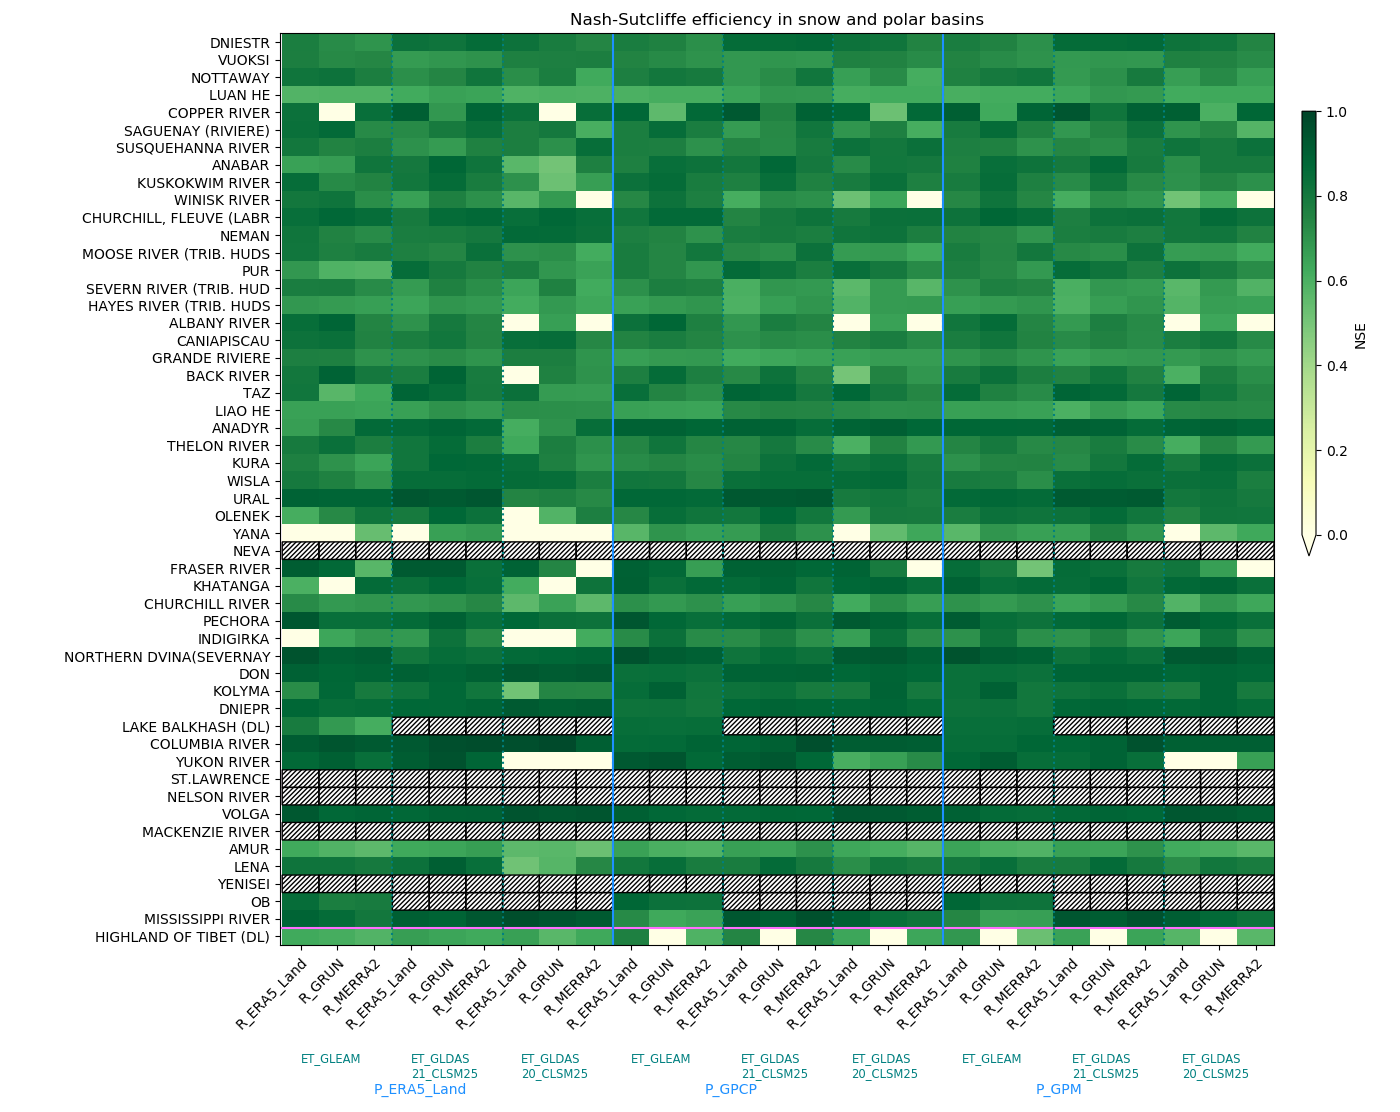

In [8]:
plot_full_performance_matrix('NSE',
    NSE_tab.loc[NSE_tab['MAIN_CLIMATE']>='D',list(no_datasets)+list(promising_datasets)],
                             discrete=False,
            width=14,title='Nash-Sutcliffe efficiency in snow and polar basins'.format(Nbasins),
            left_space=0.2,bottom_space=0.15,top_space=0.97)

## 2.3. Statistics to rank datasets combinations

Combinations are ranked per decreasing number of basins performing at least good (NSE>=0.5)

First, choose the basins you want : basins with no missing value for a selection of datasets, basins with no missing value at all, all basins

In [ ]:
full_datasets=[]
for d_P in ['CPC','CRU','ERA5_Land','GPCC','GPCP','GPM','MERRA2','MSWEP']:
    for d_ET in ['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25',
                 'GLDAS20_NOAH36','GLDAS21_NOAH36','GLDAS20_VIC412','GLDAS21_VIC412',
                 'GLDAS22_CLSM25','GLEAM','MERRA2','SSEBop']:
        for d_R in ['ERA5_Land','GLDAS20_CLSM25','GLDAS21_CLSM25',
                 'GLDAS20_NOAH36','GLDAS21_NOAH36','GLDAS20_VIC412','GLDAS21_VIC412',
                 'GLDAS22_CLSM25','GRUN','MERRA2']:
            full_datasets.append('P_{}_ET_{}_R_{}_TWS_{}'.format(d_P,d_ET,d_R,data_TWS))
full_basins=NSE_tab.index[(np.sum(np.isnan(NSE_tab[full_datasets]),axis=1)==0)]
full_basins.shape

In [ ]:
full_basins=NSE_tab.index[(np.sum(np.isnan(NSE_tab[datasets]),axis=1)==0)]
full_datasets=datasets
full_basins.shape

In [9]:
full_basins=NSE_tab.index
full_datasets=datasets
full_basins.shape

(154,)

<IPython.core.display.Javascript object>


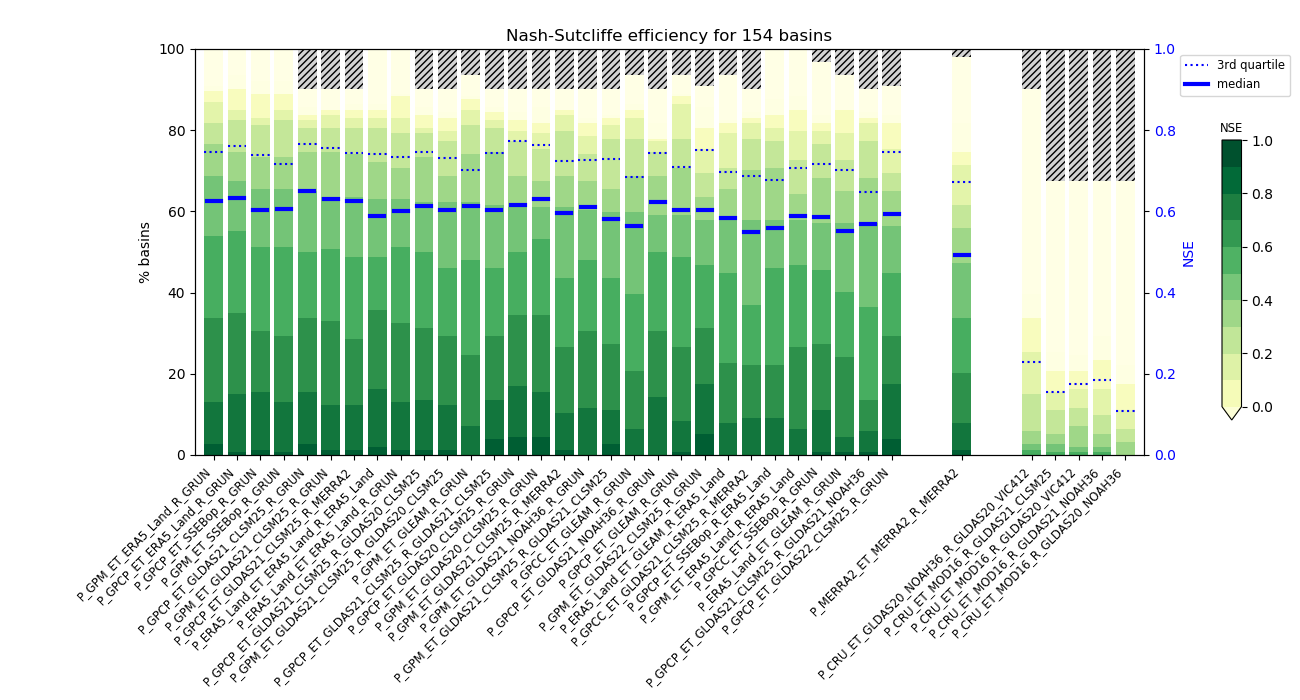

In [10]:
limitsNSE=list(np.arange(0.9,-0.1,-0.1))
my_cmap = plt.cm.get_cmap('YlGn')

# compute the number of basins in each NSE category for all datasets
select_NSE_tab=NSE_tab.loc[full_basins,full_datasets]
nb_very_good=np.sum(select_NSE_tab>=0.75,axis=0)
nb_good=np.sum(select_NSE_tab>=0.5,axis=0)

datasets_perf=nb_very_good.to_frame(name='very good')
datasets_perf['good']=nb_good

# sort datasets combinations per decreasing number of basins at least good
plot_good=30
plot_bad=5
sorted_datasets=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[:plot_good])
xdatasets=list(np.arange(plot_good))
for my_combination in ['P_ERA5_Land_ET_ERA5_Land_R_ERA5_Land_TWS_{}'.format(data_TWS),'P_MERRA2_ET_MERRA2_R_MERRA2_TWS_{}'.format(data_TWS)]:
    if not(my_combination in sorted_datasets):
        sorted_datasets.append(my_combination)
        xdatasets.append(xdatasets[-1]+3)

sorted_datasets+=list(datasets_perf.sort_values(by=['good','very good'],ascending=False).index[-plot_bad:])
xdatasets+=list(np.arange(xdatasets[-1]+3,xdatasets[-1]+3+plot_bad))

select_NSE_tab=select_NSE_tab[sorted_datasets]
nb_basins=select_NSE_tab.shape[0]
nb_datasets=select_NSE_tab.shape[1]

width=0.8

fig, ax1 = plt.subplots(figsize=(13,7))

bottom=np.zeros(nb_datasets)
for lim in limitsNSE:
    basinsNSE=100*np.sum(select_NSE_tab>=lim,axis=0)/nb_basins-bottom
    ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(lim+0.01))
    bottom+=basinsNSE

# poorest performance
basinsNSE=100*np.sum(select_NSE_tab<lim,axis=0)/nb_basins
ax1.bar(xdatasets,basinsNSE,width,bottom=bottom,color=my_cmap(0))
bottom=bottom+basinsNSE

ax1.bar(xdatasets,100-bottom,width,
        bottom=bottom,color='lightgrey',hatch='/////')


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plot medians
for i,med in zip(xdatasets,select_NSE_tab.median(axis=0)):
    line1,=ax2.plot([i-(width-0.2)/2,i+(width-0.2)/2],[med,med],'b',linewidth=3)
    
for i,med in zip(xdatasets,select_NSE_tab.quantile(0.75,axis=0)):
    line2,=ax2.plot([i-(width)/2,i+(width)/2],[med,med],'b:')

ax2.legend([line2,line1],['3rd quartile','median'],loc='upper right', bbox_to_anchor=(1.16, 1.),fontsize='small')
ax2.set_ylim([0,1])
ax2.set_ylabel('NSE',color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax1.set_xticks(xdatasets)
ax1.set_xticklabels(select_NSE_tab.columns.str[:-len(data_TWS)-5],rotation=45,ha='right',fontsize='small')
#plt.xticks(xdatasets,select_NSE_tab.columns.str[:-len(data_TWS)-5],rotation=90,fontsize='small')
ax1.set_xlim([-width,xdatasets[-1]+width])
ax1.set_ylim([0,100])

plt.title('Nash-Sutcliffe efficiency for {} basins'.format(nb_basins))
ax1.set_ylabel('% basins')  


fig.subplots_adjust(left=0.15,bottom=0.35, right=0.88, top=0.93)
cax = plt.axes([0.94, 0.4, 0.015, 0.4])
    
clb=fig.colorbar(
        ScalarMappable(cmap=plt.cm.get_cmap('YlGn'), norm=plt.Normalize(-0.1,1)),
        cax=cax,
        fraction=0.01,
        boundaries=[-0.1] + limitsNSE[::-1] + [1],  # Adding values for extensions.
        extend='min',
        ticks=[-0.1]+limitsNSE[::-1][::2]+[1],
        spacing='proportional',
    )
clb.ax.set_title('NSE',fontsize='small') 
#plt.tight_layout()
plt.show()

## 2.4. Tables of performances per hydrological variable

In [11]:
def findnth(haystack, needle, n):
    parts= haystack.split(needle, n+1)
    if len(parts)<=n+1:
        return -1
    return len(haystack)-len(parts[-1])-len(needle)

In [12]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    #return ['background-color: yellow' if v else '' for v in is_max]
    return ['font-weight: bold' if v else '' for v in is_max]

In [13]:
hydro_var_name='R'
method='all' # 'best' to compute percentage over the best combination, 'all' to compute over all combinations
climate='D' # 'all' to include all basins or a letter between 'A' and 'E' to restrict to a given climate zone

list_data=pd.Index(np.unique(data_R)).str[len(hydro_var_name)+1:]
stats=pd.DataFrame(np.zeros((list_data.shape[0],7)),index=list_data,
                   columns=['median','1st quartile','3rd quartile','% very good','% good','% acceptable','% poor'])

for data in list_data:
    select_datasets=[i for i in datasets if '{}_{}'.format(hydro_var_name,data) in i]
    
    if climate=='all':
        select_NSE_tab=NSE_tab[select_datasets]
    else:
        select_NSE_tab=NSE_tab.loc[NSE_tab['MAIN_CLIMATE']==climate,select_datasets]
    temp=select_NSE_tab.values.flatten()
    (nb_basins,nb_datasets)=select_NSE_tab.shape
    
    # do we want percentages over all basins or non-missing values ?
    #nb_nan=np.sum(np.isnan(temp))
    nb_nan=0
    
    temp=temp[~np.isnan(temp)]
    stats.loc[data,'median']=np.median(temp)
    stats.loc[data,'1st quartile']=np.percentile(temp, 25, interpolation = 'midpoint') 
    stats.loc[data,'3rd quartile']=np.percentile(temp, 75, interpolation = 'midpoint') 
    if method=='best':
        stats.loc[data,'% very good']=100*np.sum(select_NSE_tab.max(axis=1)>=0.75)/(nb_basins)
        stats.loc[data,'% good']=100*np.sum(select_NSE_tab.max(axis=1)>=0.5)/(nb_basins)
        stats.loc[data,'% acceptable']=100*np.sum(select_NSE_tab.max(axis=1)>=0.2)/(nb_basins)
        stats.loc[data,'% poor']=100*np.sum(select_NSE_tab.max(axis=1)<0.2)/(nb_basins)
    elif method=='all':
        stats.loc[data,'% very good']=100*np.sum(temp>=0.75)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% good']=100*np.sum(temp>=0.5)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% acceptable']=100*np.sum(temp>=0.2)/(nb_basins*nb_datasets-nb_nan)
        stats.loc[data,'% poor']=100*np.sum(temp<0.2)/(nb_basins*nb_datasets-nb_nan)

stats.style.apply(highlight_max)

,median,1st quartile,3rd quartile,% very good,% good,% acceptable,% poor
ERA5_Land,0.472547,0.230050,0.646844,9.967320,37.182280,62.091503,17.628903
GLDAS20_CLSM25,0.277379,-0.084094,0.516846,5.337691,20.533769,43.972404,32.570806
GLDAS20_NOAH36,0.309979,-0.007968,0.545921,5.936819,22.694263,46.332607,30.210603
GLDAS20_VIC412,0.435751,0.250104,0.612738,5.682643,30.519245,61.365287,15.177923
GLDAS21_CLSM25,0.273945,-0.025992,0.518681,4.665940,20.406681,43.409586,33.133624
GLDAS21_NOAH36,0.383749,0.175246,0.555556,4.175744,24.854757,55.755265,20.787945
GLDAS21_VIC412,0.467187,0.307094,0.605428,4.320988,34.350036,66.521423,10.021786
GLDAS22_CLSM25,0.247436,-0.072756,0.520768,5.047204,19.807553,40.450254,33.188090
GRUN,0.464693,0.224068,0.639663,7.407407,36.510530,61.111111,18.609296
MERRA2,0.441523,0.242138,0.618678,6.681191,33.097313,62.254902,17.247640


Format LaTeX tabs with optimal values in bold

In [14]:
str_latex=stats.to_latex(float_format="%.2f")
columns_descr='{} & \\thead{median} & \\thead{1st quartile} &  \\thead{3rd quartile} &'
columns_descr+='\\thead{ \\% very good \\\\ (NSE $ \\ge 0.75 $) } &'
columns_descr+='\\thead{ \\% good \\\\ (NSE $ \\ge 0.5 $) } &'
columns_descr+='\\thead{ \\% acceptable \\\\ (NSE $ \\ge 0.2 $) } &'
columns_descr+='\\thead{ \\% poor \\\\ (NSE $ < 0.2 $) }  \\\\\n'
str_latex=str_latex[:str_latex.find('\\toprule')+9]+columns_descr+str_latex[str_latex.find('\\midrule'):]

for i,col in enumerate(stats.columns[:-1]):
    best_dataset=stats.index[stats[col].argmax()]
    
    ind=str_latex.find(best_dataset.replace('_','\_'))
    first_sep=findnth(str_latex[ind:],'&',i)+ind
    second_sep=findnth(str_latex[ind:],'&',i+1)+ind
    
    #print(best_dataset,first_sep,second_sep)
    
    #first_sep=str_latex.find('&',ind)
    #second_sep=str_latex.find('&',first_sep+1)
    
    str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# add the minimum for the last column
col=stats.columns[-1]
best_dataset=stats.index[stats[col].argmin()]
    
ind=str_latex.find(best_dataset.replace('_','\_'))
first_sep=findnth(str_latex[ind:],'&',i+1)+ind
second_sep=str_latex.find('\\',first_sep+1)
str_latex=str_latex[:first_sep+1]+'\\textbf {'+str_latex[first_sep+1:second_sep].replace(" ", "") +'}'+str_latex[second_sep:]

# format datasets names
str_latex=str_latex.replace('\_',' ')
str_latex=str_latex.replace('GLDAS20','GLDAS2.0')
str_latex=str_latex.replace('GLDAS21','GLDAS2.1')
str_latex=str_latex.replace('GLDAS22','GLDAS2.2')

str_latex=str_latex.replace('CLSM25','CLSM2.5')
str_latex=str_latex.replace('NOAH36','NOAH3.6')
str_latex=str_latex.replace('VIC412','VIC4.1.2')

str_latex='\\resizebox{ \\textwidth}{!}{' + str_latex[:-1] + '}'

print(str_latex)

\resizebox{ \textwidth}{!}{\begin{tabular}{lrrrrrrr}
\toprule
{} & \thead{median} & \thead{1st quartile} &  \thead{3rd quartile} &\thead{ \% very good \\ (NSE $ \ge 0.75 $) } &\thead{ \% good \\ (NSE $ \ge 0.5 $) } &\thead{ \% acceptable \\ (NSE $ \ge 0.2 $) } &\thead{ \% poor \\ (NSE $ < 0.2 $) }  \\
\midrule
ERA5 Land      &\textbf {0.47}&          0.23 &\textbf {0.65}&\textbf {9.97}&\textbf {37.18}&         62.09 &   17.63 \\
GLDAS2.0 CLSM2.5 &    0.28 &         -0.08 &          0.52 &         5.34 &   20.53 &         43.97 &   32.57 \\
GLDAS2.0 NOAH3.6 &    0.31 &         -0.01 &          0.55 &         5.94 &   22.69 &         46.33 &   30.21 \\
GLDAS2.0 VIC4.1.2 &    0.44 &          0.25 &          0.61 &         5.68 &   30.52 &         61.37 &   15.18 \\
GLDAS2.1 CLSM2.5 &    0.27 &         -0.03 &          0.52 &         4.67 &   20.41 &         43.41 &   33.13 \\
GLDAS2.1 NOAH3.6 &    0.38 &          0.18 &          0.56 &         4.18 &   24.85 &         55.76 &   20.79 \\
G

## 2.5. Analysis per climate zone

### Equatorial regions

<IPython.core.display.Javascript object>


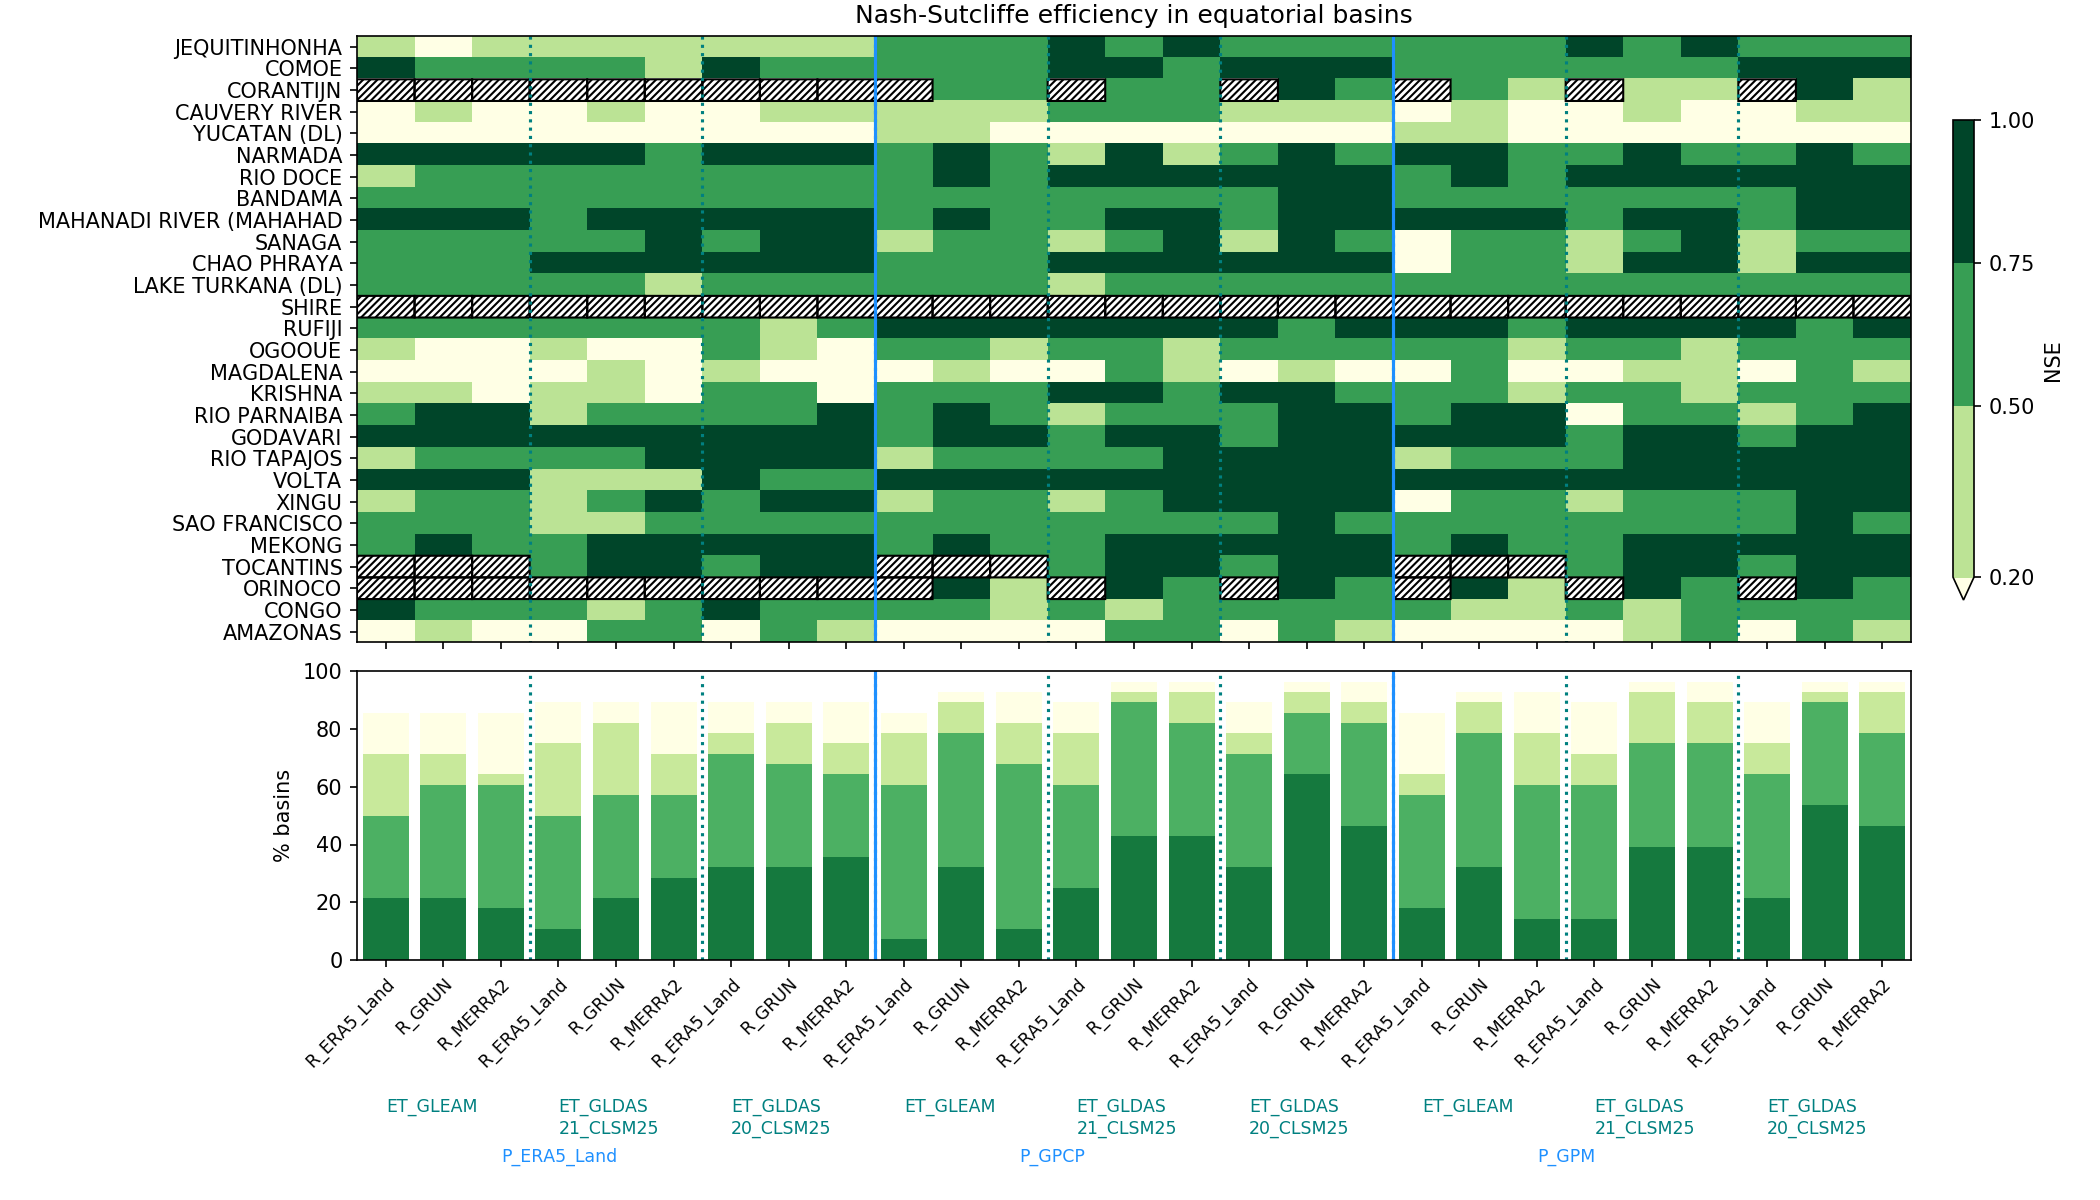

In [11]:
plot_performance_matrix('NSE_large',NSE_tab.loc[NSE_tab['MAIN_CLIMATE']=='A',list(promising_datasets)+list(no_datasets)],
                        width=14,title='Nash-Sutcliffe efficiency in equatorial basins',
                       analysis='stackplot')

### Arid regions

<IPython.core.display.Javascript object>


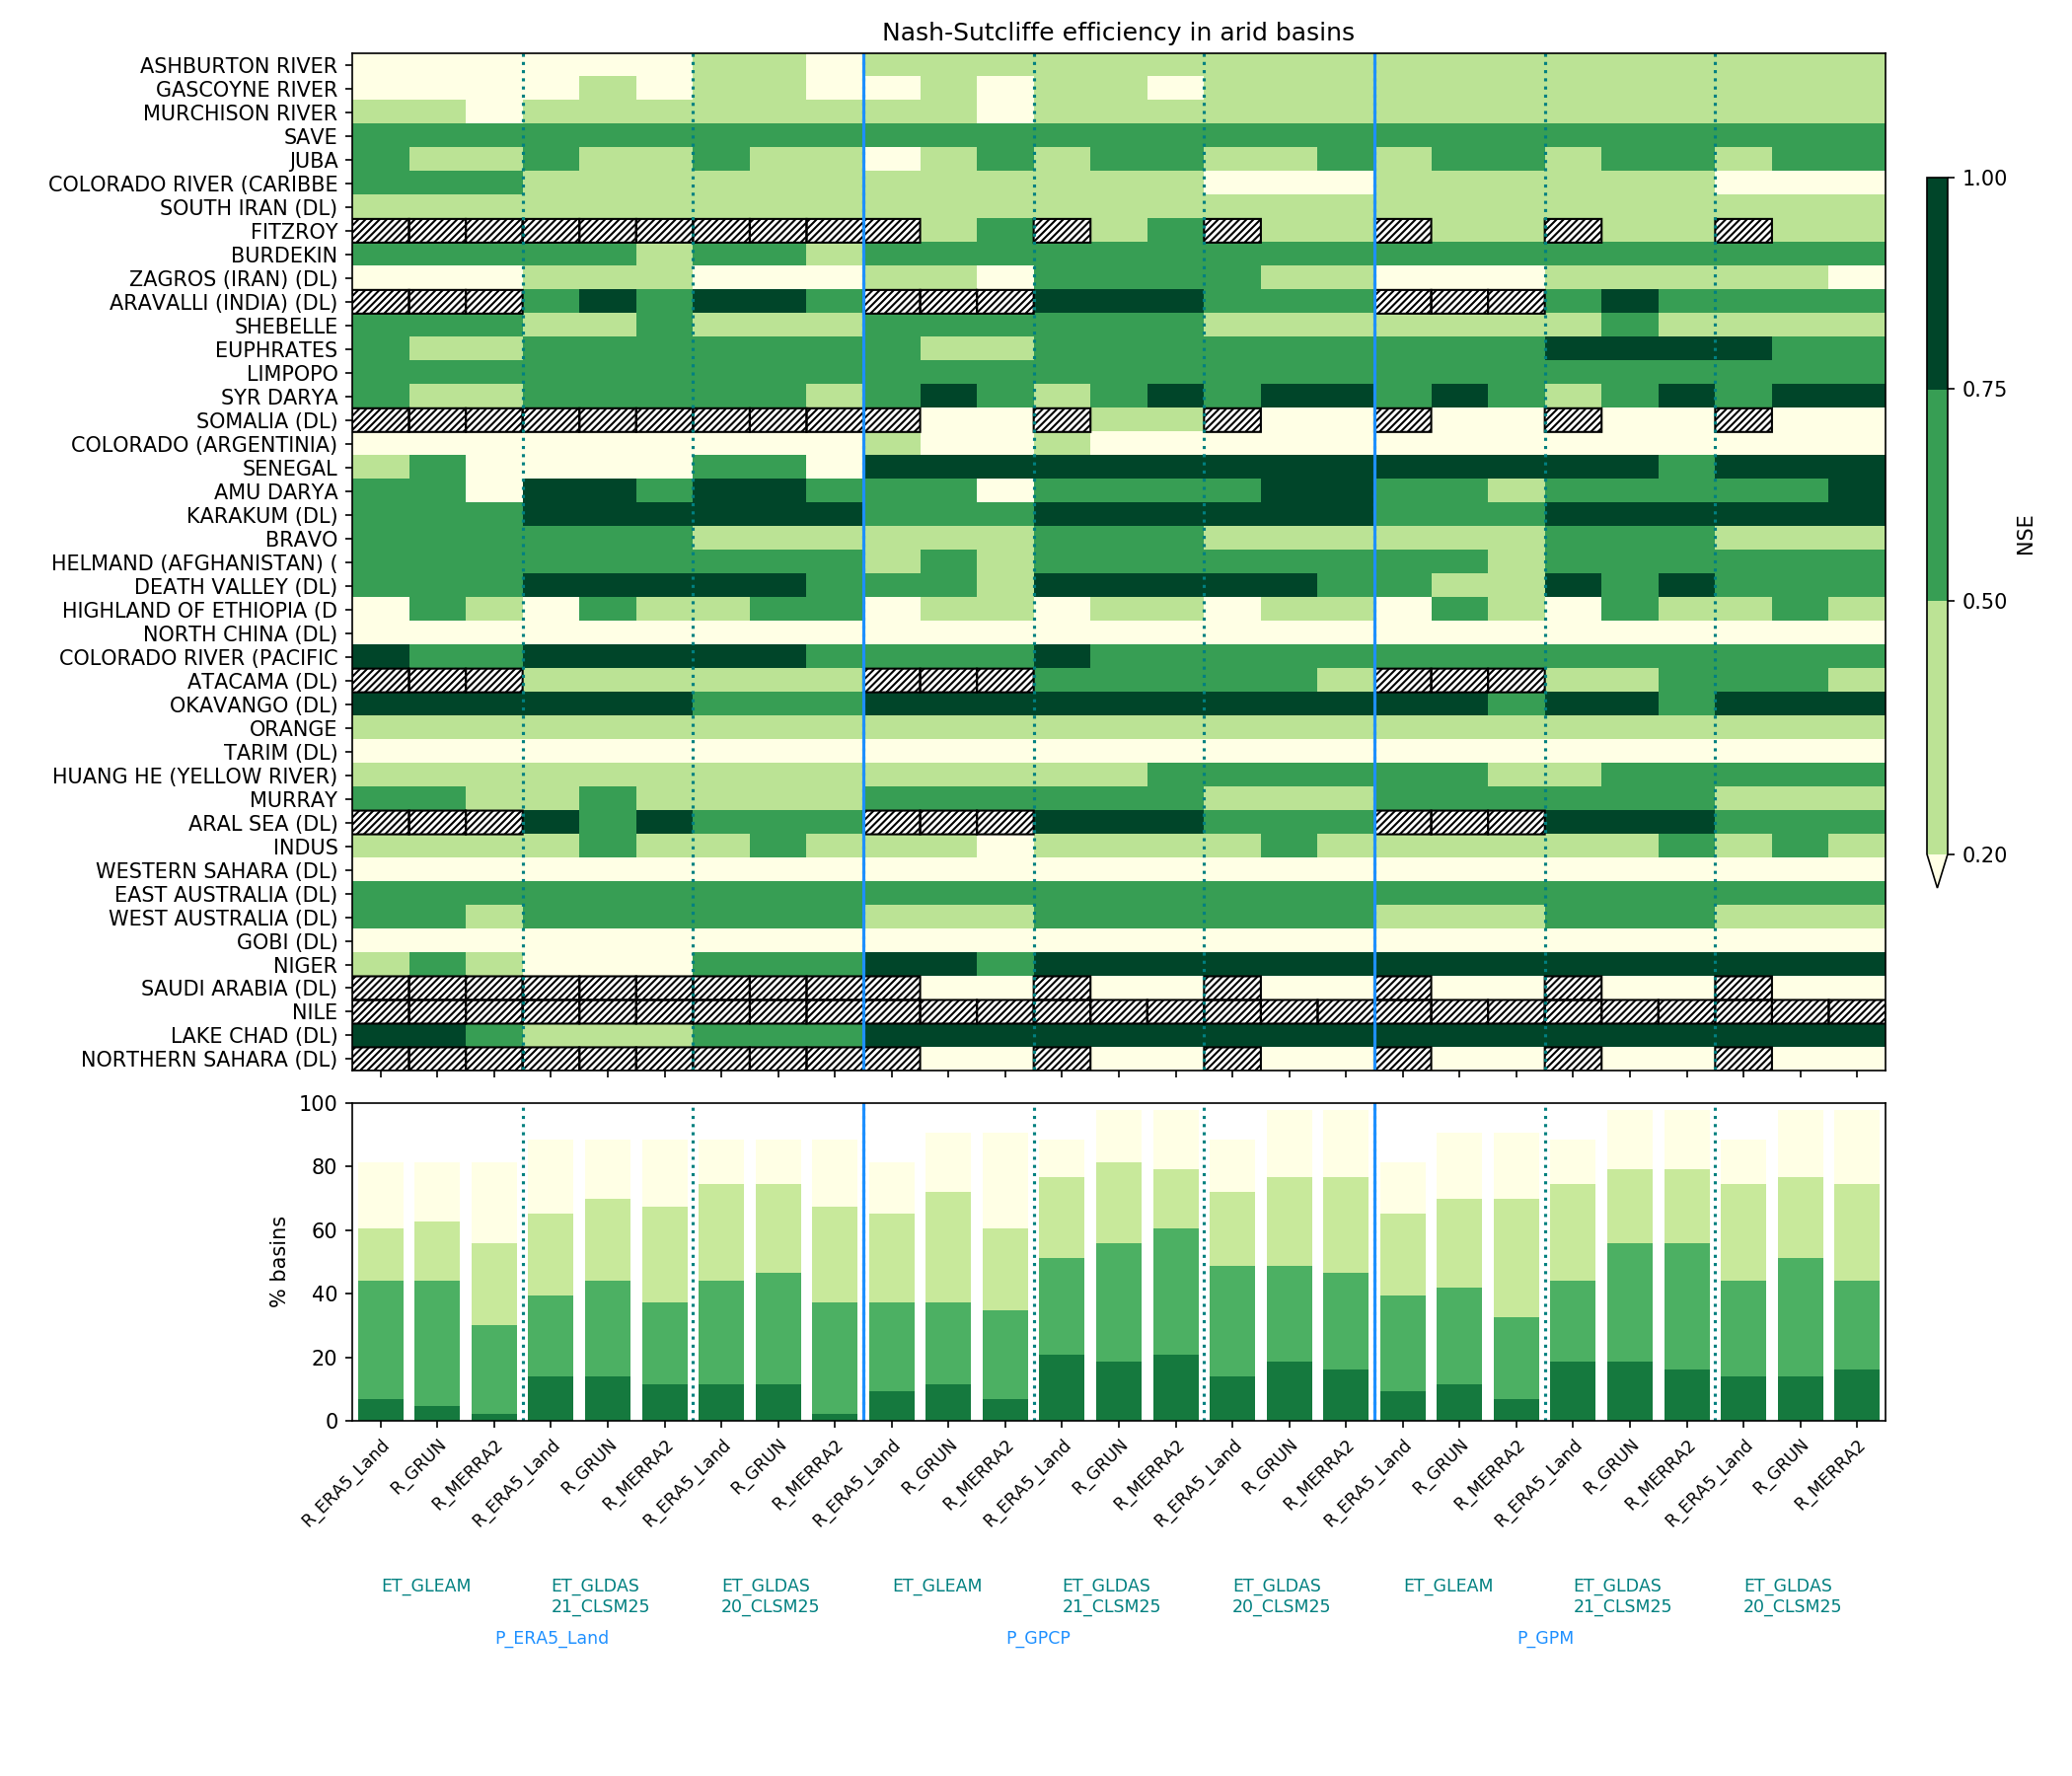

In [12]:
plot_performance_matrix('NSE_large',NSE_tab.loc[NSE_tab['MAIN_CLIMATE']=='B',list(promising_datasets)+list(no_datasets)],
                        width=14,height=12,title='Nash-Sutcliffe efficiency in arid basins',
                       analysis='stackplot')

### Warm temperate regions

<IPython.core.display.Javascript object>


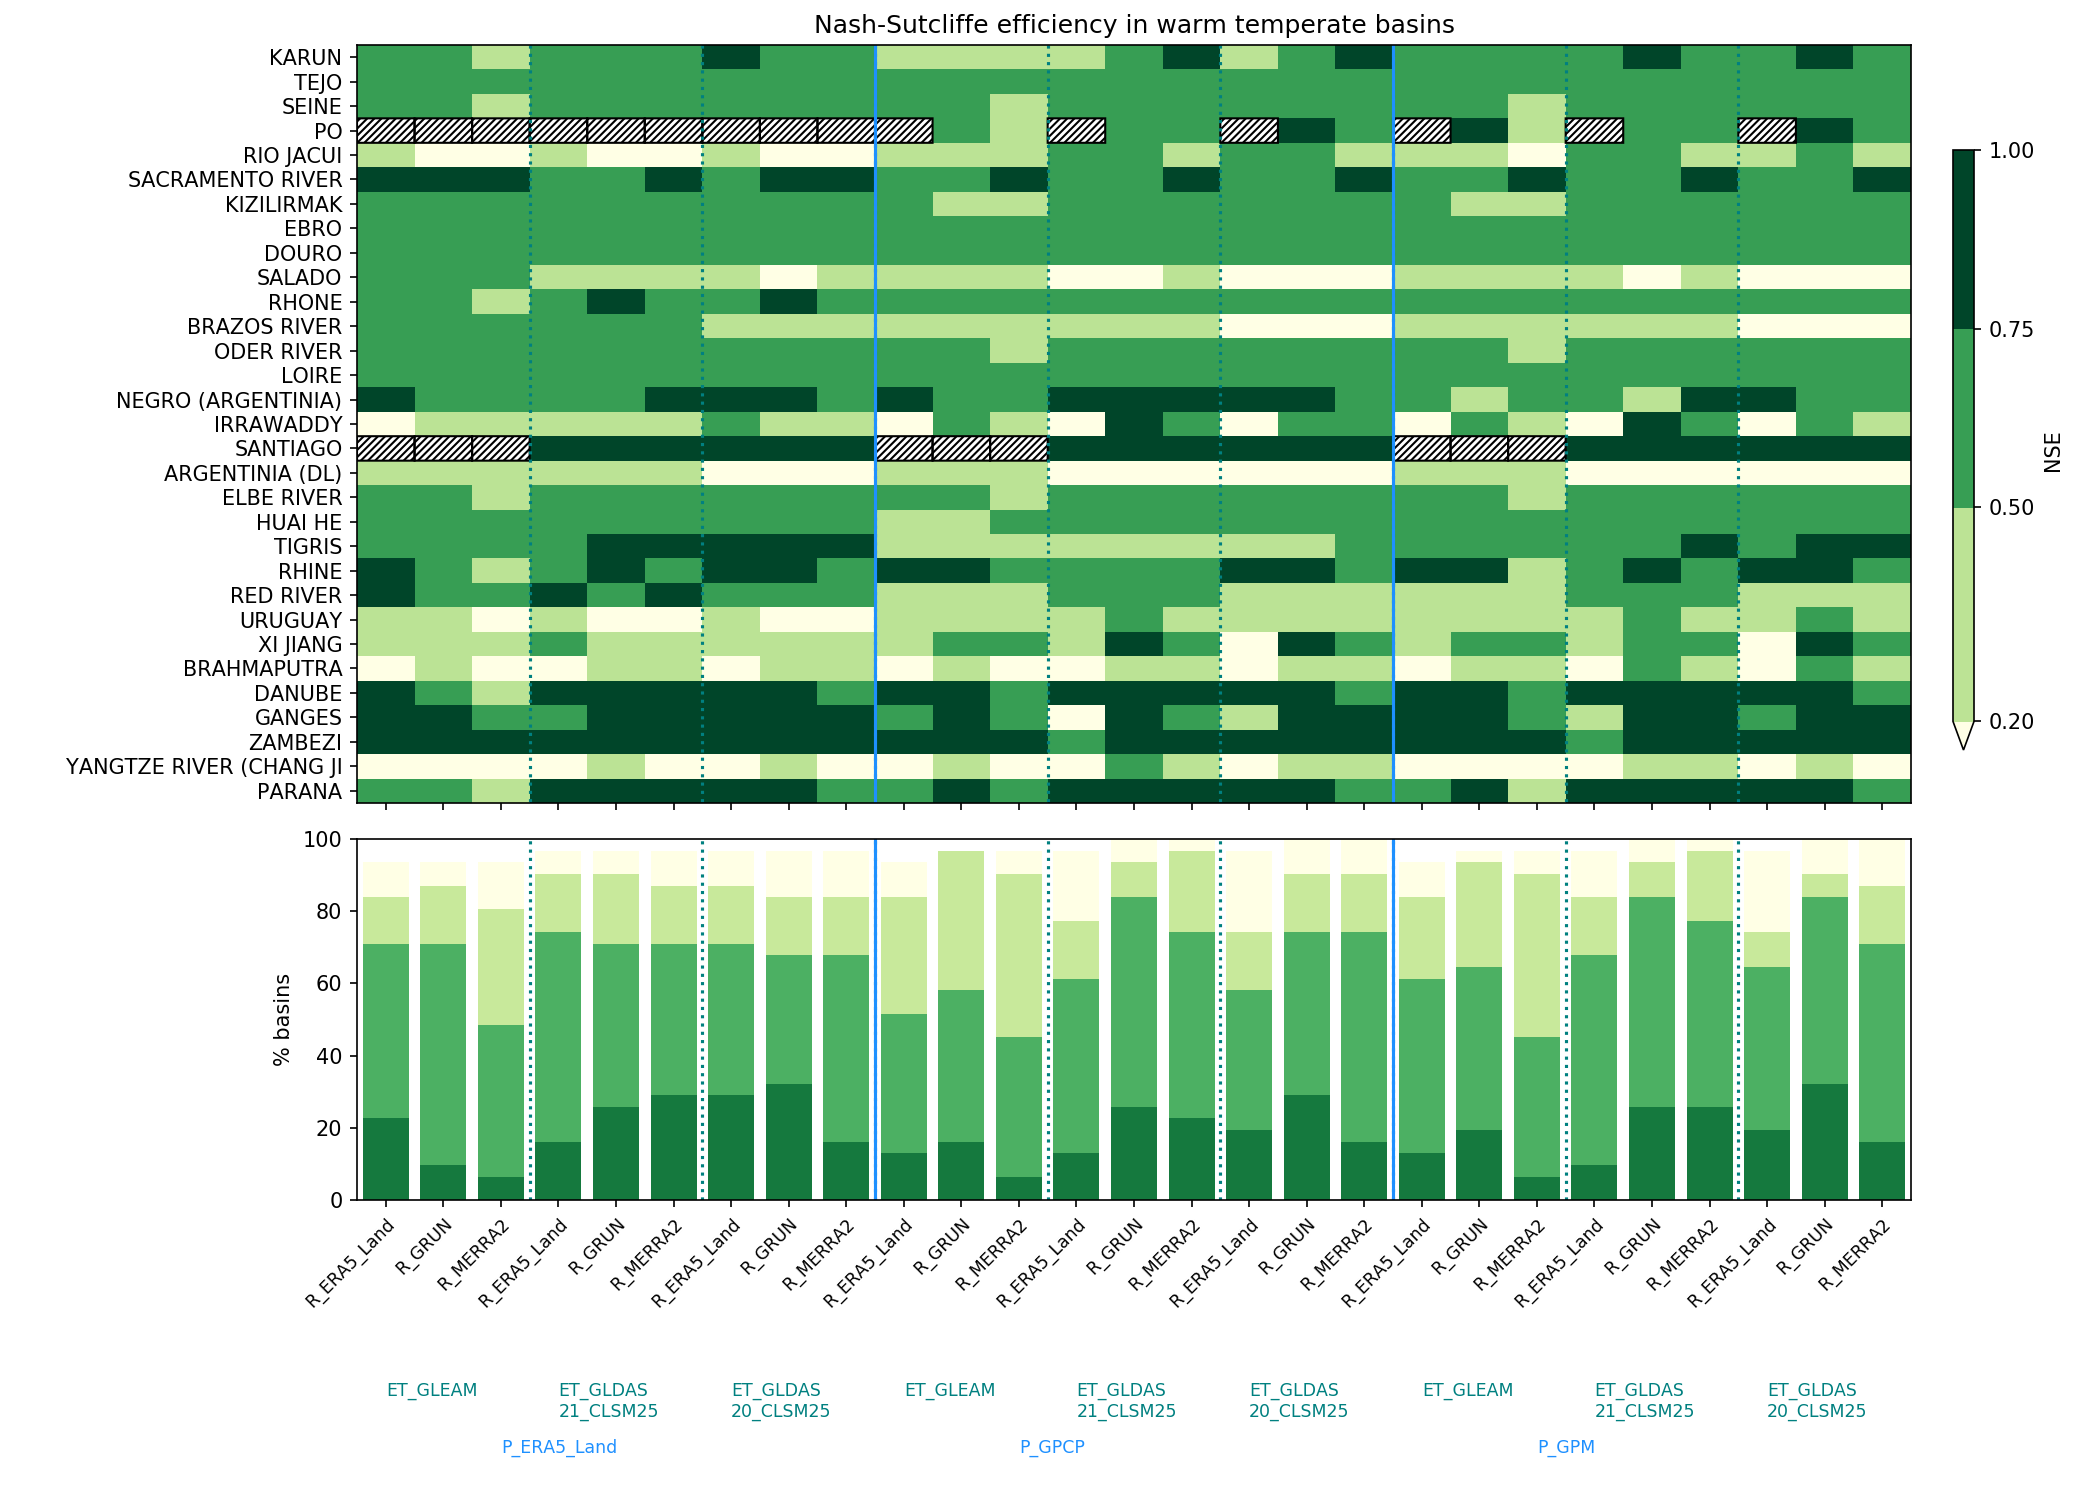

In [13]:
plot_performance_matrix('NSE_large',NSE_tab.loc[NSE_tab['MAIN_CLIMATE']=='C',list(promising_datasets)+list(no_datasets)],
                        width=14,height=10,title='Nash-Sutcliffe efficiency in warm temperate basins',
                       analysis='stackplot')

### Snow regions

<IPython.core.display.Javascript object>


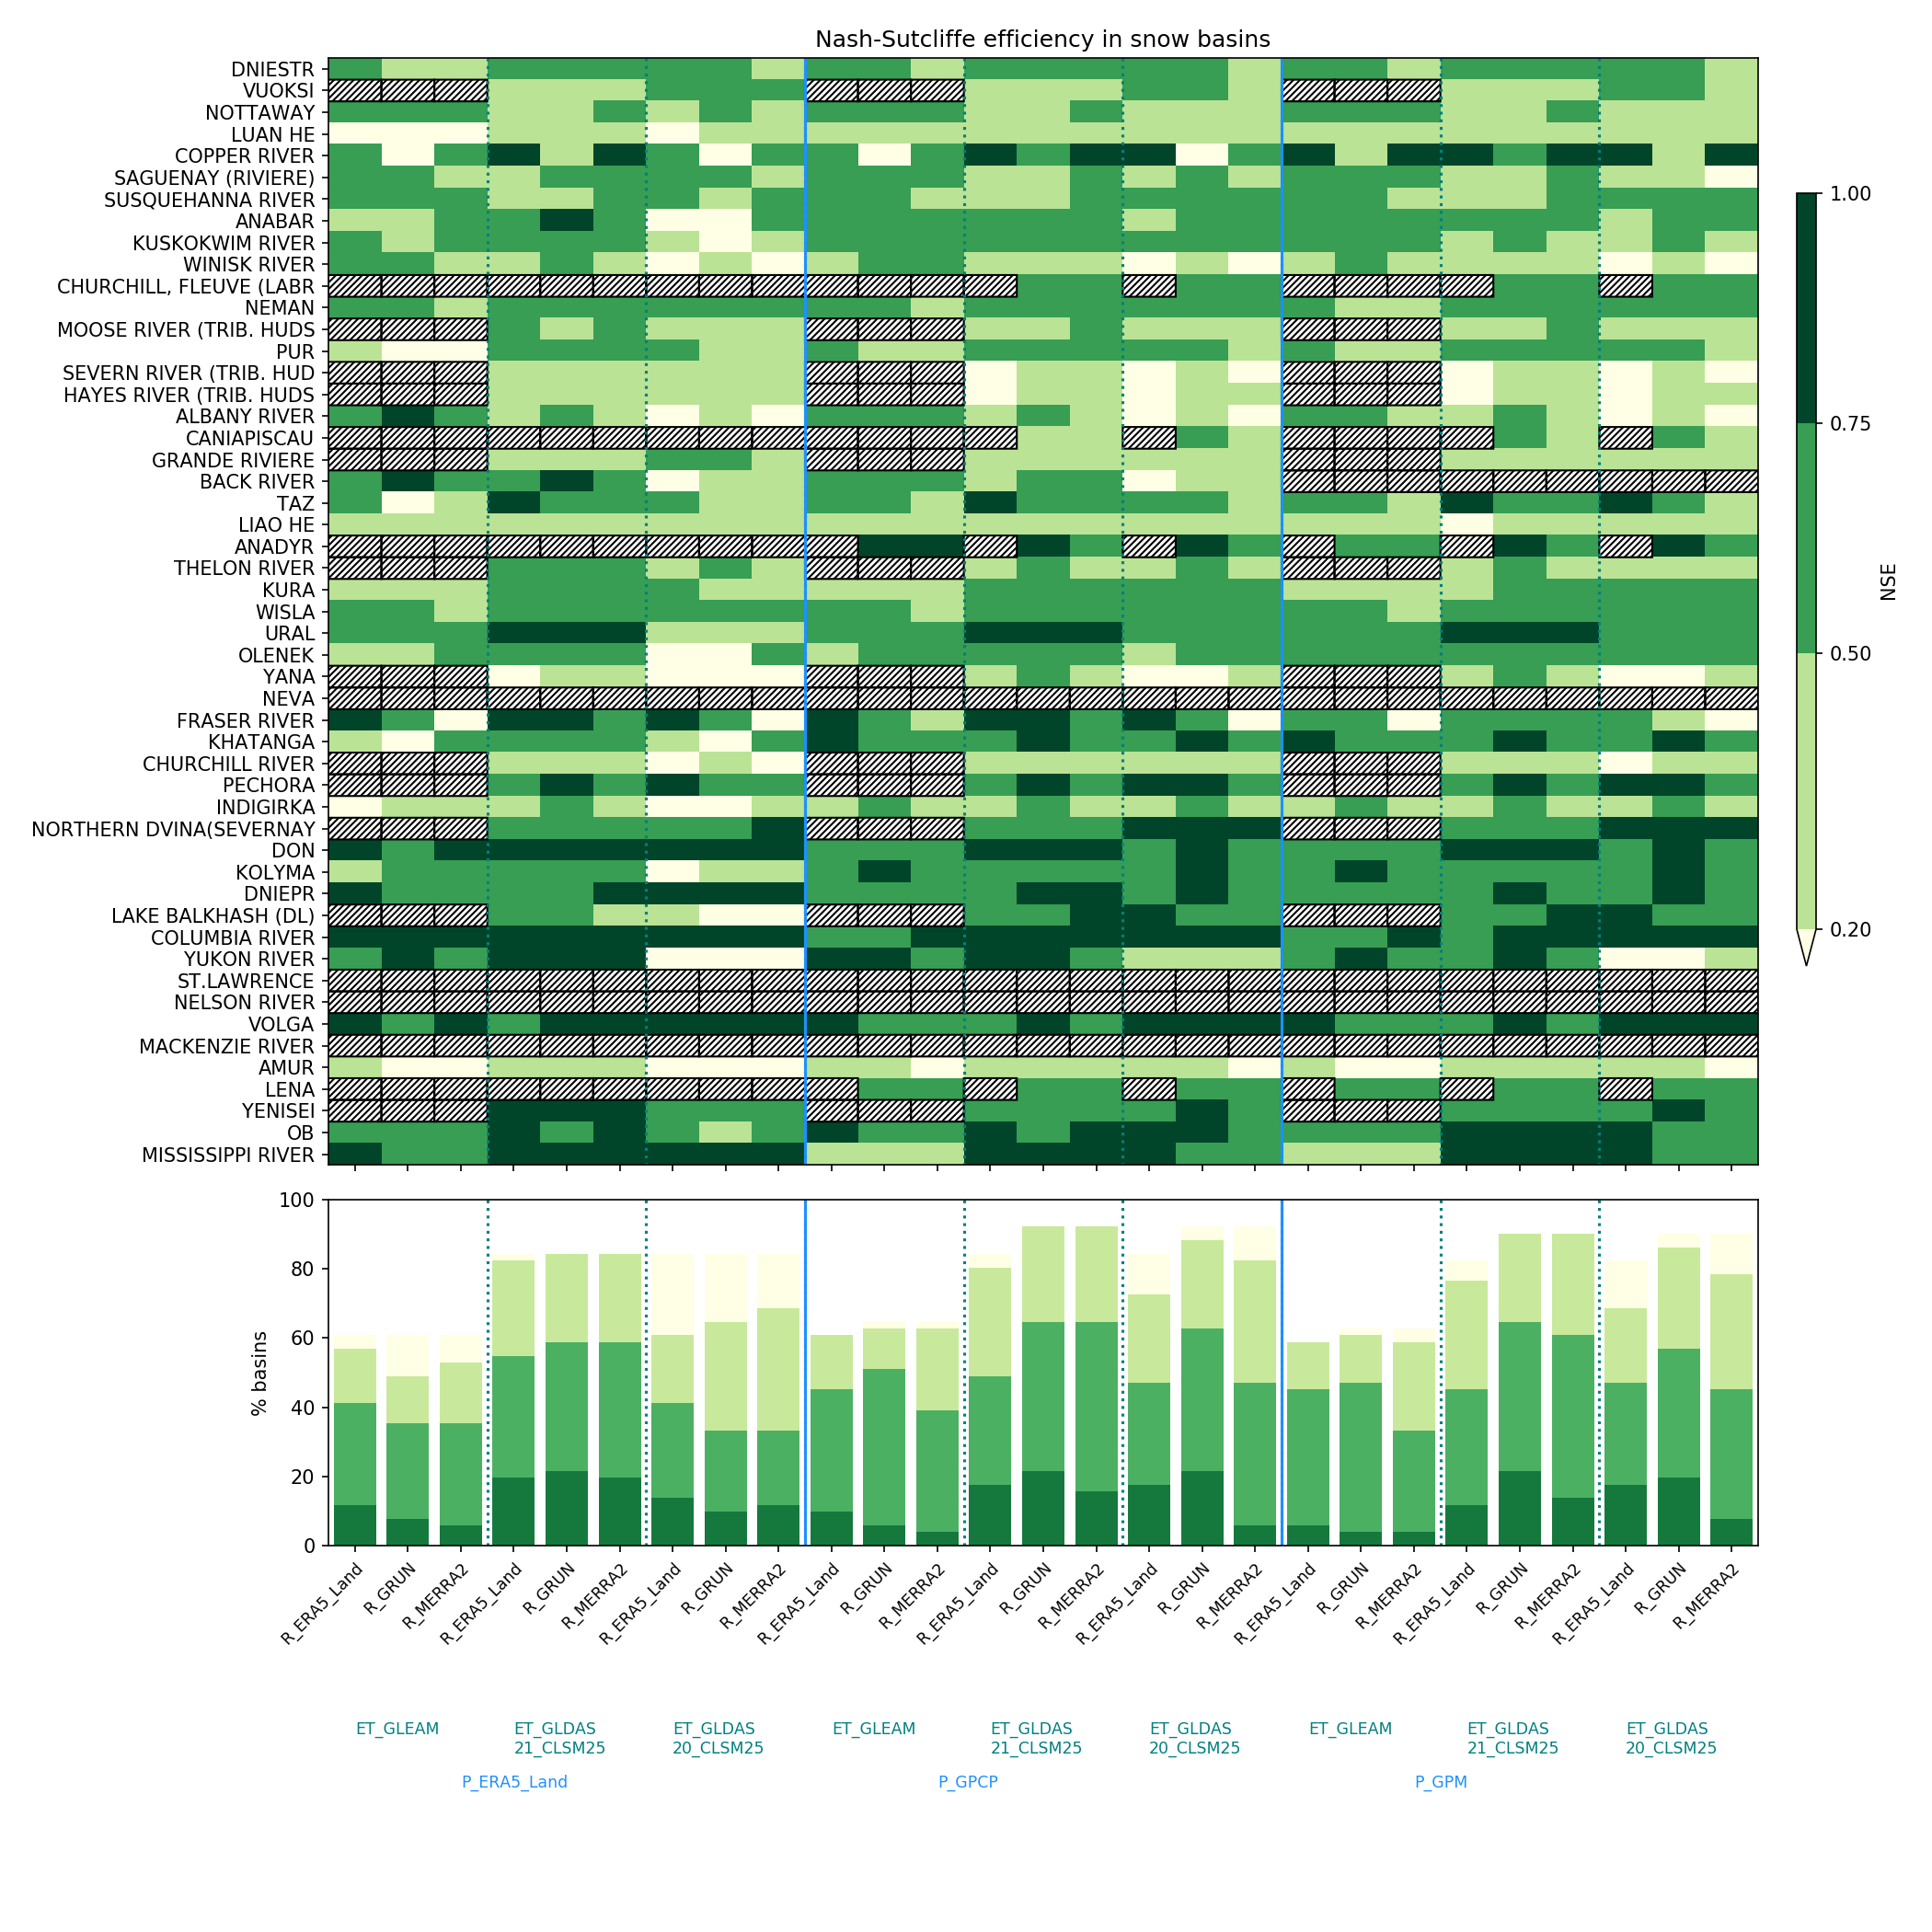

In [14]:
plot_performance_matrix('NSE_large',NSE_tab.loc[NSE_tab['MAIN_CLIMATE']=='D',list(promising_datasets)+list(no_datasets)],
                        width=14,height=14,title='Nash-Sutcliffe efficiency in snow basins',
                       analysis='stackplot')